In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, precision_score, recall_score, confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader



import warnings
warnings.filterwarnings("ignore")

/mnt/tank/scratch/rgurtsiev/miniconda3/envs/my_env/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /mnt/tank/scratch/rgurtsiev/miniconda3/envs/my_env/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


# Data

In [2]:
# if True:
#   !gdown --id 1CIFpAquzYBA98gQCdMb92fC0w6yrYf2m
#   !gdown --id 1Cfh0VIXWTc8EK96WRZdyaqgA2-JwvsUG
#   !gdown --id 1Cfh8hA9Tl8uCPrLSmcIQI3qCbEjOFl7C

In [3]:
# !mv elliptic_txs_classes.csv dataset/

In [4]:
from glob import glob 
dataset = glob('./dataset/*')
len(dataset)

3

In [5]:
df_classes = pd.read_csv(dataset[0])
df_edges = pd.read_csv(dataset[1])
df_features = pd.read_csv(dataset[2], header=None)

In [6]:
df_classes.shape

(203769, 2)

In [7]:
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})

<BarContainer object of 3 artists>

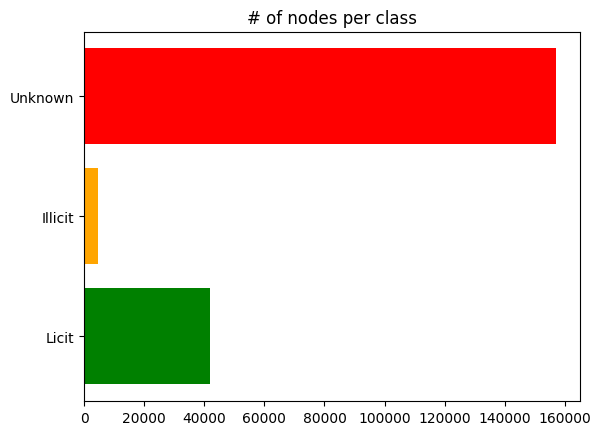

In [8]:
group_class = df_classes.groupby('class').count()
plt.title("# of nodes per class")
plt.barh([ 'Licit','Illicit', 'Unknown'], group_class['txId'].values, color=['g', 'orange', 'r'] )

In [9]:
# merge data

df_merge = df_features.merge(df_classes, how='left', right_on='txId', left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)
df_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


In [10]:
labels = df_merge['class']

In [11]:
# Edge Inde: Создадим взаимо связь между узлами
nodes = df_merge[0].values
node2idx = {j:i for i,j in enumerate(nodes)}

edges = df_edges.copy()
edges.txId1 = edges.txId1.map(node2idx)
edges.txId2 = edges.txId2.map(node2idx)
edges = edges.astype(int)

In [12]:
edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

edge_index

tensor([[138670, 141325, 139232,  ..., 100420,  54833, 101159],
        [  4142, 142201, 139223,  ..., 100419,  81951, 101163]])

In [13]:
# Создаем веса для каждой ноды
weights = torch.ones(edge_index.shape[1], dtype=torch.double)

In [14]:
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,-0.039637,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.379357,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,1.590664,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,-0.500080,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.362510,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,403203785,28,-0.172978,-0.172527,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
203765,403234712,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792,2
203766,403234715,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792,2
203767,403235564,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792,2


In [15]:
classified_idx = node_features['class'].loc[node_features['class']!=2].index
unclassified_idx = node_features['class'].loc[node_features['class']==2].index

classified_illicit_idx = node_features['class'].loc[node_features['class']==1].index
classified_licit_idx = node_features['class'].loc[node_features['class']==0].index

In [16]:
node_features = node_features.drop(columns=[0, 1, 'class'])
node_features.head()

,2,3,4,5,6,7,8,9,10,11,...,157,158,159,160,161,162,163,164,165,166
0,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,-0.164980,-0.009283,...,0.073047,-0.039637,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399
1,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,-0.167757,-0.038545,...,1.228858,0.379357,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288
2,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,1.321754,-0.049707,...,1.348450,1.590664,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772
3,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,-0.166062,-0.049707,...,-0.577099,-0.500080,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
4,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,-0.081943,-0.049707,...,0.501062,0.362510,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601


In [17]:
node_features_t = torch.tensor(np.array(node_features.values), dtype=torch.double)
node_features_t

tensor([[-0.1685,  0.2709, -0.0914,  ...,  1.1516,  1.5197,  1.5214],
        [-0.1708, -0.1314,  1.0186,  ..., -0.1221, -0.3800, -0.3793],
        [ 1.3052, -0.2106, -1.7564,  ..., -0.1310,  0.0070,  0.0178],
        ...,
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1433, -0.1588, -1.2014,  ..., -0.0975, -0.1206, -0.1198]],
       dtype=torch.float64)

In [18]:
node_features_t.shape, nodes.shape

(torch.Size([203769, 165]), (203769,))

# Train test split

In [19]:
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_idx, valid_idx = train_test_split(classified_idx.values, test_size=0.15)

In [20]:
node_features_t = torch.tensor(node_features_t, dtype=torch.float32).to(device)
edge_index = torch.tensor(edge_index, dtype=torch.long).to(device)
weights = torch.tensor(weights, dtype=torch.float32).to(device)
labels = torch.tensor(labels, dtype=torch.float32).to(device)

data_train = Data(x=node_features_t, edge_index=edge_index, edge_attr=weights, 
                               y=torch.tensor(labels, dtype=torch.float32))

data_train.train_idx = torch.tensor(train_idx, dtype=torch.long).to(device)
data_train.valid_idx = torch.tensor(valid_idx, dtype=torch.long).to(device)
data_train.test_idx = torch.tensor(unclassified_idx, dtype=torch.long).to(device)

# Model

In [21]:
import torch
# import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
# from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree

from torch_geometric.nn import GCNConv,GATConv,GATv2Conv
import pickle

In [22]:
class MetricManager(object):
    def __init__(self, modes=["train", "val"]):
        self.output = {}
    
        for mode in modes:
          self.output[mode] = {}
          self.output[mode]["accuracy"] = []
          self.output[mode]["f1micro"] = []
          self.output[mode]["f1macro"] = []
          self.output[mode]["roc_auc"] = []
    
          self.output[mode]["precision"] = []
          self.output[mode]["recall"] = []
          self.output[mode]["cm"] = []

    
    def store_metrics(self, mode, pred_scores, target_labels, threshold=0.5):
        pred_labels = pred_scores > threshold
        accuracy = accuracy_score(target_labels, pred_labels)
        f1micro = f1_score(target_labels, pred_labels,average='micro')
        f1macro = f1_score(target_labels, pred_labels,average='macro')
        aucroc = roc_auc_score(target_labels, pred_scores)

        recall = recall_score(target_labels, pred_labels)
        precision = precision_score(target_labels, pred_labels)
        cm = confusion_matrix(target_labels, pred_labels)
    
        self.output[mode]["accuracy"].append(accuracy)
        self.output[mode]["f1micro"].append(f1micro)
        self.output[mode]["f1macro"].append(f1macro)
        self.output[mode]["roc_auc"].append(aucroc)

        self.output[mode]["recall"].append(recall)
        self.output[mode]["precision"].append(precision)
        self.output[mode]["cm"].append(cm)
        
        return accuracy, f1micro,f1macro, aucroc,recall,precision,cm
      
    def get_best(self, metric, mode="val"):
        best_results = {}
        i = np.array(self.output[mode][metric]).argmax()
    
        for m in self.output[mode].keys():
          best_results[m] = self.output[mode][m][i]
        
        return best_results

In [27]:
class Trainer:
    def __init__(self, model):
        self.model = model
        self.metric_manager = MetricManager(modes=['train','val'])

    def train(self, data_train, optimizer, loss_fun, scheduler, args):

        self.data_train = data_train
        self.model.train()
        for epoch in range(args['epochs']):
            
            optimizer.zero_grad()
            
            y_pred = self.model(data_train).flatten()
            loss = loss_fun(y_pred[data_train.train_idx], data_train.y[data_train.train_idx])

            y_target = data_train.y[data_train.train_idx].detach().cpu().numpy()
            pred_scores = y_pred[data_train.train_idx].detach().cpu().numpy()


            train_acc, train_f1, train_f1macro, train_roc_auc, train_recall, train_precision, train_cm = self.metric_manager.store_metrics("train", pred_scores, y_target)
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Eval
            model.eval()
            y_target = data_train.y[data_train.valid_idx].detach().cpu().numpy()
            pred_scores = y_pred[data_train.valid_idx].detach().cpu().numpy()
            val_acc, val_f1,val_f1macro, val_roc_auc, val_recall, val_precision, val_cm = self.metric_manager.store_metrics("val", pred_scores, y_target)

            if epoch % 50 == 0:
                print("epoch: {} - loss: {:.4f} - accuracy train: {:.4f} -accuracy valid: {:.4f}  - val roc: {:.4f}  - val f1micro: {:.4f}".format(epoch, loss.item(), train_acc, val_acc, val_roc_auc, val_f1))

# GAT

In [326]:
# Static update weigths

class GAT(nn.Module):
    def __init__(self, 
                 in_channels, 
                 hidden_dim, 
                 out_channels, 
                 heads, 
                 args
    ):
        super(GAT, self).__init__()

        self.dropout = args.get('dropout') if args else 0.5
        self.training_flag = args.get('training', True) if args else True

        self.layers = nn.ModuleList([
            pyg_nn.GATConv(in_channels=in_channels, out_channels=hidden_dim, heads=heads),
            pyg_nn.GATConv(in_channels=hidden_dim * heads, out_channels=hidden_dim, heads=heads),
        ])

        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * heads, hidden_dim),
            nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, out_channels)
        )
    
    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index

        for gat in self.layers:
            x = gat(x, edge_index)
            x = F.dropout(F.relu(x), p=self.dropout, training=self.training_flag)

        x = self.mlp(x)
        return torch.sigmoid(x)

# GATv2Conv

In [280]:
class GATv2(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, args):
        super(GATv2, self).__init__()

        heads = args.get('heads')
        
        self.dropout = args.get('dropout') 
        self.training_flag = args.get('training', True) if args else True
        
        self.layers = nn.ModuleList([
            pyg_nn.GATv2Conv(in_channels=in_channels, out_channels=hidden_dim, heads=heads),
            pyg_nn.GATv2Conv(in_channels=hidden_dim * heads, out_channels=hidden_dim, heads=heads),
        ])  
        self.mlp = nn.Sequential(
            nn.Linear(heads * hidden_dim, hidden_dim),
            nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, out_channels)    
        )

    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index

        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.dropout(F.relu(x), p=self.dropout, training=self.training_flag)

        x = self.mlp(x)
        return torch.sigmoid(x)

# GCN

In [330]:
class GCN(nn.Module):
    def __init__(self, 
                 in_channels, 
                 hidden_dim,
                 out_channels, 
                 args                 
    ):
        super(GCN, self).__init__()
        torch.manual_seed(22)

        heads = args['heads']

        self.layers = nn.ModuleList([
            pyg_nn.GCNConv(in_channels=in_channels, out_channels=hidden_dim, normalize=True),
            pyg_nn.GCNConv(in_channels=hidden_dim, out_channels=out_channels, normalize=True)
        ])
        self.mlp = nn.Linear(out_channels, 1)

    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = layer(x, edge_index)
            x = x.tanh()

        x = self.mlp(x)        
        return torch.sigmoid(x)

# GraphSAGE

In [24]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, num_layers, args):
        super(GraphSAGE, self).__init__()

        self.dropout = args['dropout']        
        self.layers = nn.ModuleList([
            pyg_nn.GraphSAGE(in_channels=in_channels, hidden_channels=hidden_dim, out_channels=out_channels, num_layers=num_layers),
            pyg_nn.GraphSAGE(in_channels=in_channels, hidden_channels=hidden_dim, out_channels=out_channels, num_layers=num_layers),
        ])
        
        self.linear = nn.Linear(out_channels, in_channels)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, 2 * in_channels),
            nn.Dropout(self.dropout),
            nn.Linear(2 * in_channels, 1)
        )
        
    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index

        for layer in self.layers:
            x = layer(x, edge_index)
            x = self.linear(x)
        
        x = self.mlp(x)
        return torch.sigmoid(x)

In [46]:
class GIN(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(GIN, self).__init__()
        
        nn1 = nn.Sequential(
            nn.Linear(in_channels, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.layers = nn.ModuleList([
            pyg_nn.GINConv(nn1, eps=0.1),
            pyg_nn.GINConv(nn1, eps=0.5),
        ])
        
        self.additional_layer = nn.Linear(hidden_dim, in_channels)
        self.mlp = nn.Linear(hidden_dim, out_channels)
        

    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = layer(x, edge_index)
            x = self.additional_layer(x)
        
        x = self.mlp(x)
        return torch.sigmoid(x)

# Train GCN

In [333]:
from transformers import get_cosine_schedule_with_warmup

args = {
    "epochs":101,
    'lr':0.01,
    'weight_decay':1e-5,
    'prebuild':True,
    'heads': 4,
    'training': True,
    'hidden_dim': 128, 
    'dropout': 0.5
}

in_channels = data_train.x.shape[1]
hidden_dim = args['hidden_dim']
out_channels = 1
heads = args['heads']


model = GCN(in_channels=in_channels, hidden_dim=hidden_dim, out_channels=out_channels, args=args)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
model = model.to(device)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=10, 
    num_training_steps=50
)
loss_fun = torch.nn.BCELoss()

In [334]:
gсn_trainer = Trainer(model)
gсn_trainer.train(data_train, optimizer, loss_fun, scheduler, args)

epoch: 0 - loss: 0.4128 - accuracy train: 0.9028 -accuracy valid: 0.9004  - val roc: 0.5338  - val f1micro: 0.9004
epoch: 50 - loss: 0.3233 - accuracy train: 0.9028 -accuracy valid: 0.9004  - val roc: 0.9145  - val f1micro: 0.9004
epoch: 100 - loss: 0.2546 - accuracy train: 0.9028 -accuracy valid: 0.9004  - val roc: 0.9505  - val f1micro: 0.9004


In [337]:
from transformers import get_cosine_schedule_with_warmup

args = {
    "epochs":101,
    'lr':0.01,
    'weight_decay':1e-5,
    'prebuild':True,
    'heads': 4,
    'training': True,
    'hidden_dim': 128, 
    'dropout': 0.5
}

in_channels = data_train.x.shape[1]
hidden_dim = args['hidden_dim']
out_channels = 1
heads = args['heads']

model = GATv2(in_channels=in_channels, hidden_dim=hidden_dim, out_channels=out_channels, args=args)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
model = model.to(device)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=10, 
    num_training_steps=50
)
loss_fun = torch.nn.BCELoss()

In [338]:
gсn_trainer = Trainer(model)
gсn_trainer.train(data_train, optimizer, loss_fun, scheduler, args)

epoch: 0 - loss: 0.7324 - accuracy train: 0.4772 -accuracy valid: 0.4733  - val roc: 0.5359  - val f1micro: 0.4733
epoch: 50 - loss: 0.1335 - accuracy train: 0.9603 -accuracy valid: 0.9569  - val roc: 0.9707  - val f1micro: 0.9569
epoch: 100 - loss: 0.0541 - accuracy train: 0.9833 -accuracy valid: 0.9772  - val roc: 0.9846  - val f1micro: 0.9772


In [340]:
from transformers import get_cosine_schedule_with_warmup

args = {
    "epochs":101,
    'lr':0.01,
    'weight_decay':1e-5,
    'prebuild':True,
    'heads': 4,
    'training': True,
    'hidden_dim': 128, 
    'dropout': 0.5
}

in_channels = data_train.x.shape[1]
hidden_dim = args['hidden_dim']
out_channels = 1
heads = args['heads']

model = GAT(in_channels=in_channels, hidden_dim=hidden_dim, out_channels=out_channels,heads=heads, args=args)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
model = model.to(device)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=10, 
    num_training_steps=50
)
loss_fun = torch.nn.BCELoss()

In [341]:
gсn_trainer = Trainer(model)
gсn_trainer.train(data_train, optimizer, loss_fun, scheduler, args)

epoch: 0 - loss: 0.8132 - accuracy train: 0.3457 -accuracy valid: 0.3591  - val roc: 0.4697  - val f1micro: 0.3591
epoch: 50 - loss: 0.1470 - accuracy train: 0.9509 -accuracy valid: 0.9480  - val roc: 0.9659  - val f1micro: 0.9480
epoch: 100 - loss: 0.0758 - accuracy train: 0.9764 -accuracy valid: 0.9709  - val roc: 0.9839  - val f1micro: 0.9709


In [35]:
from transformers import get_cosine_schedule_with_warmup

args = {
    "epochs":101,
    'lr':0.01,
    'weight_decay':1e-5,
    'prebuild':True,
    'heads': 4,
    'training': True,
    'hidden_dim': 128, 
    'dropout': 0.5
}

in_channels = data_train.x.shape[1]
hidden_dim = args['hidden_dim']
out_channels = 1
heads = args['heads']

model = GraphSAGE(in_channels=in_channels, hidden_dim=hidden_dim, out_channels=out_channels, num_layers=2, args=args)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
model = model.to(device)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=10, 
    num_training_steps=50
)
loss_fun = torch.nn.BCELoss()

In [36]:
gсn_trainer = Trainer(model)
gсn_trainer.train(data_train, optimizer, loss_fun, scheduler, args)

epoch: 0 - loss: 0.8178 - accuracy train: 0.1533 -accuracy valid: 0.1449  - val roc: 0.4999  - val f1micro: 0.1449
epoch: 50 - loss: 0.1828 - accuracy train: 0.9332 -accuracy valid: 0.9346  - val roc: 0.9233  - val f1micro: 0.9346
epoch: 100 - loss: 0.0693 - accuracy train: 0.9776 -accuracy valid: 0.9696  - val roc: 0.9791  - val f1micro: 0.9696


In [44]:
from transformers import get_cosine_schedule_with_warmup

args = {
    "epochs":101,
    'lr':0.01,
    'weight_decay':1e-5,
    'prebuild':True,
    'heads': 4,
    'training': True,
    'hidden_dim': 128, 
    'dropout': 0.5
}

in_channels = data_train.x.shape[1]
hidden_dim = args['hidden_dim']
out_channels = 1
heads = args['heads']

model = GIN(in_channels=in_channels, hidden_dim=hidden_dim, out_channels=out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
model = model.to(device)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=10, 
    num_training_steps=50
)
loss_fun = torch.nn.BCELoss()

In [45]:
gсn_trainer = Trainer(model)
gсn_trainer.train(data_train, optimizer, loss_fun, scheduler, args)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (203769x128 and 165x128)